In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# ルートディレクトリを指定
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# pathにルートディレクトリを追加
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# pathに(ルートディレクトリ+samples/coco/)を追加
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco

%matplotlib inline 

# logとmodelの保存用ディレクトリを作成
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# 訓練済み重みファイルのパスを指定
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# 訓練済み重みファイルのパスが存在していなければ訓練済み重みファイルをダウンロード
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# 検知対象の写真があるディレクトリを指定
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# modelインスタンス準備
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# modelに訓練済み重みをロード
model.load_weights(COCO_MODEL_PATH, by_name=True)


# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [0]:
#1, numpy zerosで型枠を準備

# #オリジナル画像のサイズを指定
#複数枚ある場合は最初の画像を指定
orignal_image = Image.open("/gdrive/My Drive/Colab Notebooks/data/images/picture000.jpg")
w,h = orignal_image.size

#png形式で保存
orignal_image.save('orignal_image.png')

In [0]:
#画像フォルダを指定

IMAGE_DIR2 = "/gdrive/My Drive/Colab Notebooks/data/images/"
file_names = next(os.walk(IMAGE_DIR2))[2]

In [0]:
box_data = []

resize_height = 0

for file_name in file_names:
    image = skimage.io.imread(os.path.join(IMAGE_DIR2, file_name))

    # 検知実行
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    
    for r,ids in zip(r["rois"],r['class_ids']):
        
        #idsが1(person)以外はスキップ処理
        if ids != 1:
            continue
        
        #バウンディングボックスの高さをリサイズ
        if resize_height != 0:
            resized_r = r[0]+int((r[2]-r[0])/resize_height)
            r[0] = resized_r
            
        box_data.append([ids,r])
        

In [0]:
#3,　検知領域としてnumpy zerosへ数値を加算

data = np.zeros((h, w, 3), dtype=np.uint8)

for i in box_data:
    loc1 = int(i[1][0])
    loc2 = int(i[1][1])
    loc3 = int(i[1][2])+1
    loc4 = int(i[1][3])+1
    data[loc1:loc3,loc2:loc4] += 1


In [0]:
#度数分布設定

_,bin= np.histogram(data, bins=5,range=(0,data.max()+1))

In [0]:
#4,　加算数値をRGB数値へと置換

blue = [29,72,119]
green = [27,138,90]
yellow = [251,176,33]
orange = [255,77,0]
red = [177,32,0]

data = np.where((data >= 1) & (data < int(bin[1])), 1, data)
data = np.where((data >= int(bin[1])) & (data < int(bin[2])), 2, data)
data = np.where((data >= int(bin[2])) & (data < int(bin[3])), 3, data)
data = np.where((data >= int(bin[3])) & (data < int(bin[4])), 4, data)
data = np.where((data >= int(bin[4])) & (data < int(bin[5])), 5, data)


for n,i in enumerate([blue,green,yellow,orange,red],1):
    data = np.where(data == n, i, data)
    
data = data.astype('uint8')


In [0]:
#5,　png画像として保存

img = Image.fromarray(data, 'RGB')
img.save('data_tmp_image.png')

In [0]:
#6,　透過画像を作成し、png画像として保存

# 透過したい画像の読み込み
org = Image.open("data_tmp_image.png")

# 同じサイズの画像を作成
trans = Image.new('RGBA', org.size, (0, 0, 0, 0))
width = org.size[0]
height = org.size[1]
for x in range(width):
    for y in range(height):
        pixel = org.getpixel( (x, y) )
        
        # 値が０であれば処理しない
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        # 用意した画像にピクセルを書き込み
        trans.putpixel( (x, y), pixel )
        
trans.save('tmp_final.png')

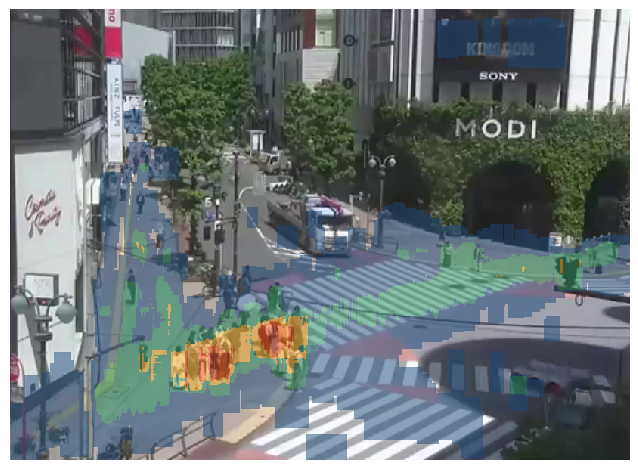

In [0]:
#7,　オリジナル画像と重ね合わせて保存

my_dpi=96

plt.figure(figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi,frameon=False)
plt.tick_params(labelbottom=False,bottom=False)
plt.tick_params(labelleft=False,left=False)
plt.axis('off')


org_image = Image.open('orignal_image.png')
heatmap_image = Image.open("tmp_final.png")

plt.imshow(org_image)
plt.imshow(heatmap_image,alpha=0.5)

plt.savefig('works9.png')
plt.show()